# Использование tsfresh + Ridge для прогноза временного ряда MOEX

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame, impute

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from tqdm import tqdm

import datetime

from IPython.display import clear_output

import seaborn as sns

from scipy.stats import t, norm, chi2, f

import scipy.stats as sts

Прочитаем данные:

In [2]:
m = pd.read_csv('moex.me.csv', delimiter = ';', error_bad_lines = False)

In [3]:
m = m[m['High'].notna()]

In [212]:
m

,Date,Open,High,Low,Close
0,04.03.2013,1473.540039,1477.270020,1461.489990,1464.449951
1,05.03.2013,1485.040039,1486.729980,1485.040039,1486.420044
2,06.03.2013,1485.040039,1498.020020,1485.040039,1491.489990
3,07.03.2013,1491.989990,1498.290039,1489.020020,1491.349976
4,11.03.2013,1503.979980,1506.420044,1503.640015,1505.930054
...,...,...,...,...,...
1918,14.12.2020,3293.000000,3314.199951,3249.360107,3254.830078
1919,15.12.2020,3252.679932,3284.840088,3237.870117,3248.110107
1920,16.12.2020,3259.889893,3275.679932,3242.699951,3269.949951
1921,17.12.2020,3277.669922,3318.389893,3274.449951,3282.669922


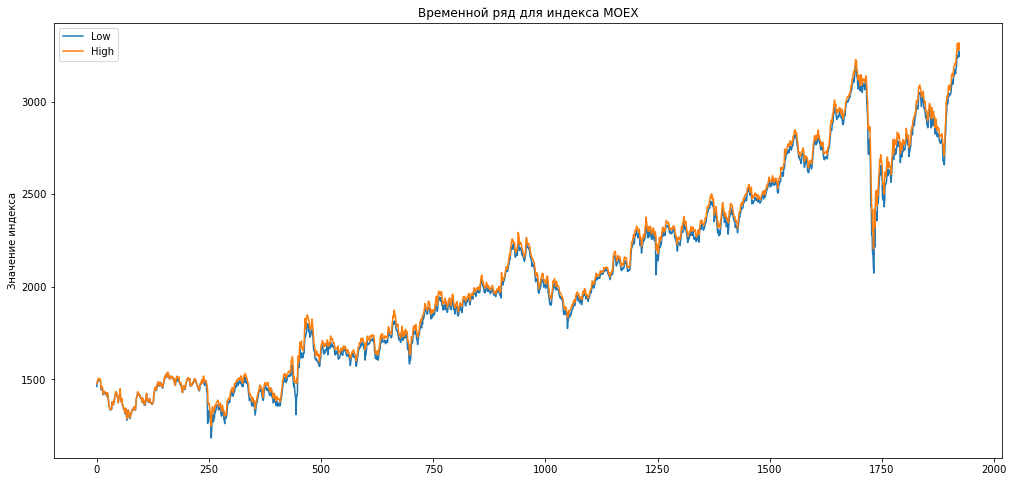

In [192]:
plt.figure(figsize=(17, 8))
m[['Low', 'High']].plot(ax=plt.gca())
plt.title('Временной ряд для индекса MOEX')
plt.ylabel('Значение индекса')
plt.show()

Обучим модель для предсказания значения **High** последующего дня, и так сделаем 101 раз

100%|██████████| 101/101 [2:50:52<00:00, 101.51s/it]


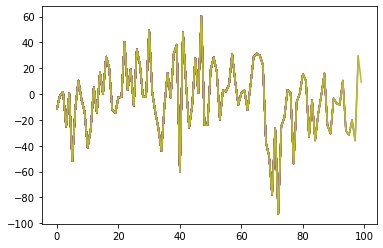

In [57]:
errors = np.array([])
for x in tqdm(range(101, 0, -1)):
    if len(errors) > 1:
        plt.plot(errors)
    df_m = df_melted[:-x]
    y_true = df_melted.iloc[-x].High
    df_rolled = roll_time_series(df_m, column_id="Symbols", column_sort="Date",
                                max_timeshift=10, min_timeshift=2)
    X = extract_features(df_rolled.drop("Symbols", axis=1), 
                         column_id="id", column_sort="Date", column_value="High", 
                         impute_function=impute, show_warnings=False)
    X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
    X.index.name = "last_date"
    y = df_melted.set_index("Date").sort_index().High.shift(1)
    y = y[y.index.isin(X.index)]
    X = X[X.index.isin(y.index)]
    X_train_selected = select_features(X, y)
    y = y[1:]
    y.index = X.index[:-1]
    ada = Ridge(0.001)
    ada.fit(X_train_selected[:-1], y)
    y_pred = ada.predict(X_train_selected[-1:])
    errors = np.append(errors, y_pred - y_true)
    clear_output()

In [205]:
m

,Date,Open,High,Low,Close
0,04.03.2013,1473.540039,1477.270020,1461.489990,1464.449951
1,05.03.2013,1485.040039,1486.729980,1485.040039,1486.420044
2,06.03.2013,1485.040039,1498.020020,1485.040039,1491.489990
3,07.03.2013,1491.989990,1498.290039,1489.020020,1491.349976
4,11.03.2013,1503.979980,1506.420044,1503.640015,1505.930054
...,...,...,...,...,...
1918,14.12.2020,3293.000000,3314.199951,3249.360107,3254.830078
1919,15.12.2020,3252.679932,3284.840088,3237.870117,3248.110107
1920,16.12.2020,3259.889893,3275.679932,3242.699951,3269.949951
1921,17.12.2020,3277.669922,3318.389893,3274.449951,3282.669922


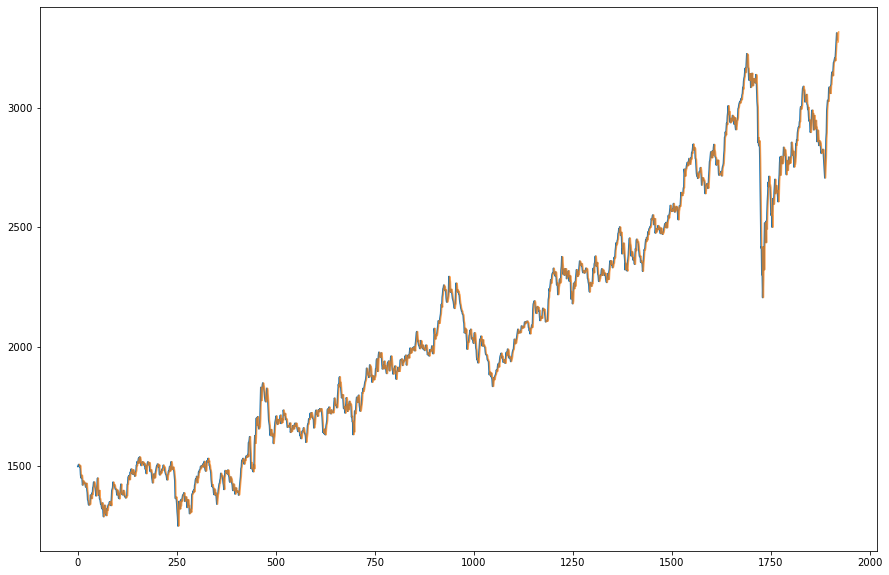

In [210]:
plt.figure(figsize = (15, 10))
plt.plot(ada.predict(X_train_selected[:-1]))
plt.plot(m.High[4:-1], alpha = 0.7)

Посмотрим на ошибки, относительные ошибки и MAPE

In [152]:
e = errors / df_melted.High.iloc[-101:]
e = e.reset_index(drop = True)

In [156]:
mape = 100 * np.abs(errors) / df_melted.High.iloc[-101:]
mape = mape.reset_index(drop = True)

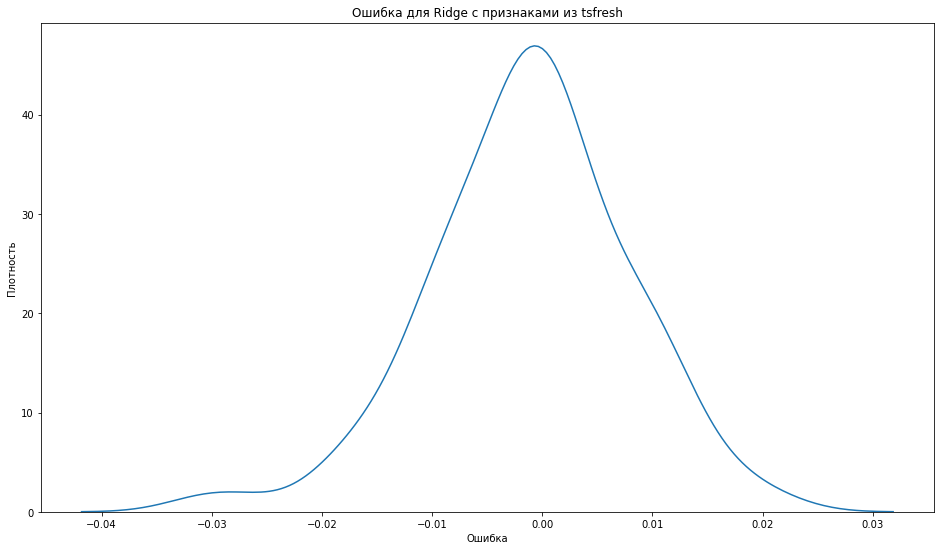

In [146]:
plt.figure(figsize = (16, 9))
sns.kdeplot(e)
plt.title('Ошибка для Ridge с признаками из tsfresh')
plt.xlabel('Ошибка')
plt.ylabel('Плотность')
plt.show()

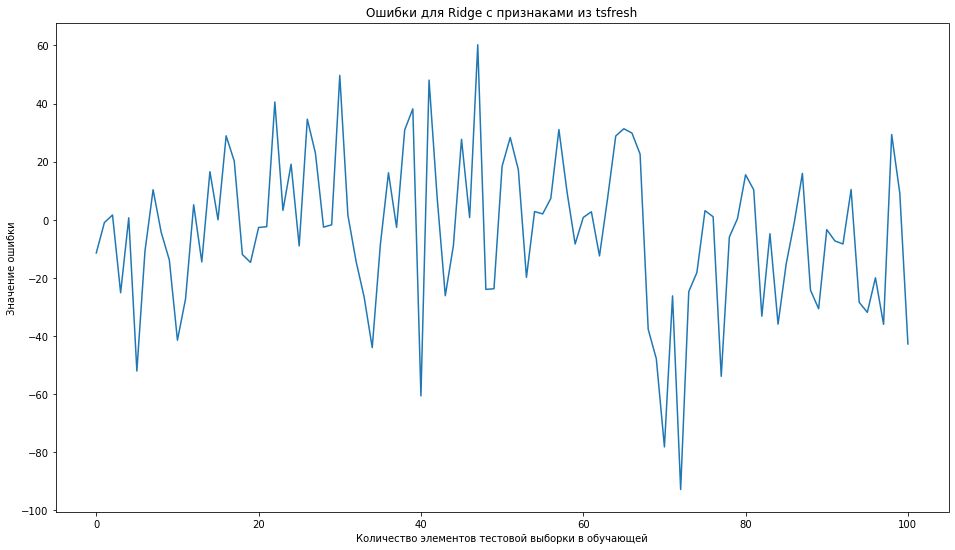

In [211]:
plt.figure(figsize = (16, 9))
plt.plot(errors)
plt.title('Ошибки для Ridge с признаками из tsfresh')
plt.xlabel('Количество элементов тестовой выборки в обучающей')
plt.ylabel('Значение ошибки')
plt.show()

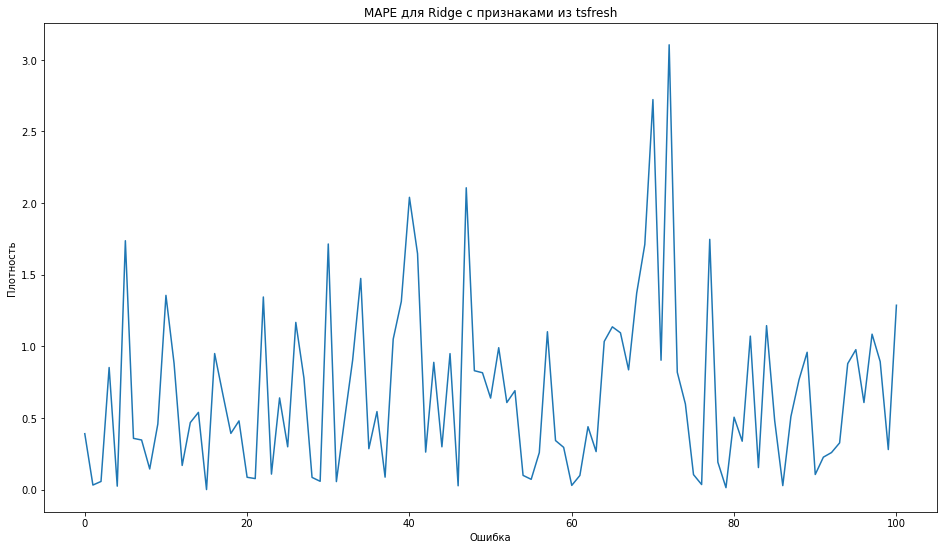

In [158]:
plt.figure(figsize = (16, 9))
plt.plot(mape)
plt.title('MAPE для Ridge с признаками из tsfresh')
plt.xlabel('Ошибка')
plt.ylabel('Плотность')
plt.show()

В целом, кажется, что относительные ошибки распределены нормально с математическим ожиданием 0. Проверим гипотезу о том, что математическое ожидание равно нулю:

In [160]:
def h2_1(const: float, mean: float, var: float, n: int, coinfidence: float) -> np.array:
    cnt = (mean - const) / np.sqrt(var / n)
    crit = t.ppf((1 + coinfidence) / 2, n - 1)
    print('Расчетная статистика равна {}'.format(cnt))
    print('Критическая статистика равна {}'.format(crit))
    p = 2 * t.cdf(cnt, n - 1)
    print('p-value = {}'.format(p))
    if np.abs(cnt) >= np.abs(crit):
        print('Нулевая гипотеза отвергается')
    else:
        print('Нет оснований отвергать нулевую гипотезу')

In [161]:
h2_1(0, e.mean(), e.var(), 101, 0.95)

Расчетная статистика равна -1.4096407427848847
Критическая статистика равна 1.9839715184496334
p-value = 0.16174826611971285
Нет оснований отвергать нулевую гипотезу


Можем с некой уверенностью сказать, что мат. ожидание относительных ошибок равно нулю. Но данная гипотеза не позволяет проверить, нормальное ли распределение у ошибок. Воспользуемся критерием Колморогорова:

In [186]:
def kolmogorov(arr: np.array, distr, alpha: float) -> np.array:
    arr = np.array(arr)
    x = sts.kstest(arr, distr)
    print('Расчетная статистика равна {}'.format(x[0]))
    print('p-value = {}'.format(x[1]))
    print('Критическое значение смотреть в таблице в пересечении строки n = {} и столбца alpha = {}'.format(len(arr), alpha))
    if alpha >= x[1]:
        print('Нулевая гипотеза отвергается')
    else:
        print('Нет оснований отвергать нулевую гипотезу')

In [187]:
kolmogorov(e, sts.norm(0, np.sqrt(101 / 102 * e.var())).cdf, 0.05)

Расчетная статистика равна 0.11552072821294257
p-value = 0.12466865335299578
Критическое значение смотреть в таблице в пересечении строки n = 101 и столбца alpha = 0.05
Нет оснований отвергать нулевую гипотезу


Как мы видим, мы можем предположить нормальность распределения ошибок. Посмотрим на плотности:

In [188]:
n = sts.norm.rvs(loc = 0, scale = np.sqrt(101 / 102 * e.var()), size = 1000000, random_state = 29)

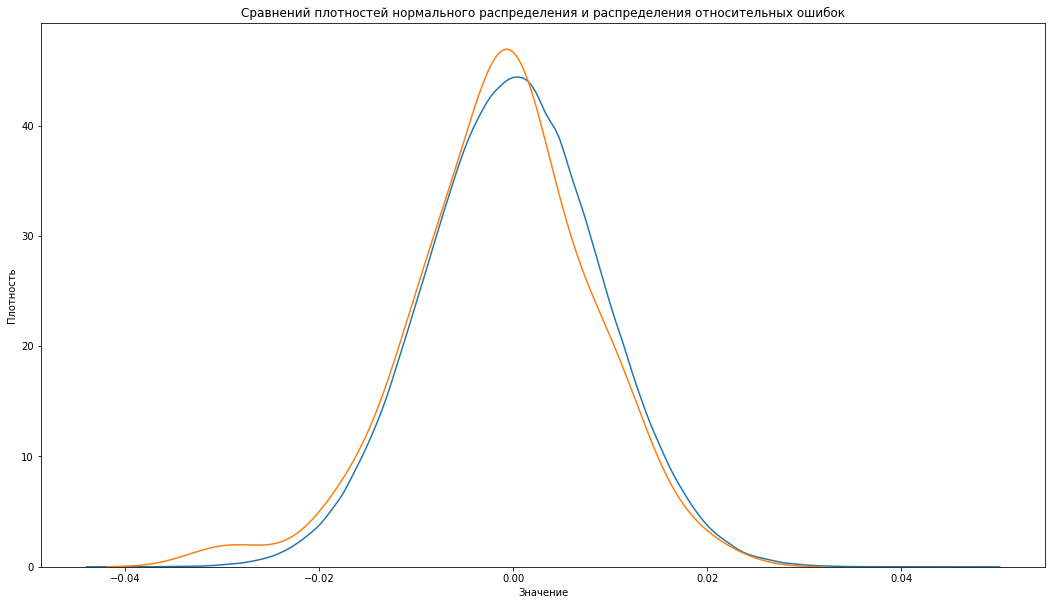

In [191]:
plt.figure(figsize = (18, 10))
sns.kdeplot(n, label = 'Выборка из нормального распределения')
sns.kdeplot(e, label = 'Относительные ошибки прогноза')
plt.title('Сравнений плотностей нормального распределения и распределения относительных ошибок')
plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.show()